# Alaska Oil & Gas Lease Analysis - Geospatial Analysis

## Overview
This notebook focuses on the geographic and spatial aspects of Alaska OCS leases, including mapping, spatial patterns, and geographic insights.


In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import folium
from folium import plugins
import json
import numpy as np
import seaborn as sns
from shapely.geometry import Point
import warnings
warnings.filterwarnings('ignore')

print("Geospatial libraries imported successfully")

Geospatial libraries imported successfully


## 1. Loading Geospatial Data

In [2]:
# Load the GeoJSON data
gdf = gpd.read_file('../data/AK_Leases.geojson')

print(f"Geospatial dataset shape: {gdf.shape}")
print(f"CRS (Coordinate Reference System): {gdf.crs}")
print(f"Geometry type: {gdf.geometry.geom_type.unique()}")

# Display first few rows
gdf.head()

Geospatial dataset shape: (2446, 40)
CRS (Coordinate Reference System): EPSG:4326
Geometry type: ['Polygon' 'MultiPolygon']


,OBJECTID,LEASE_NUMBER,BUS_ASC_NAME,IBLA_APPEAL_FLAG,LEASE_EXPIR_DATE,LEASE_STATUS_CD,LEASE_EFF_DATE,LEASE_EXPT_EXPIR,LEASE_STATUS_CHANGE_DT,LEASE_SECT_AREA,...,AREA_CODE,AC_LAB,DATUM_CODE,TRACT_NUMBER,MMS_PLAN_AREA_CD,LEASE_IS_ACTIVE,NOTES,Shape__Area,Shape__Length,geometry
0,1,Y01129,TEXACO,None,1994-04-25 00:00:00+00:00,RELINQ,1988-05-01 00:00:00+00:00,1998-04-30 00:00:00+00:00,1994-04-25 00:00:00+00:00,0.00,...,BI,BI985,0,1129,BFT,N,None,0.005419,0.337942,"POLYGON ((-142.01096 70.04633, -141.88494 70.0..."
1,2,Y01151,TEXACO,None,1994-04-25 00:00:00+00:00,RELINQ,1988-05-01 00:00:00+00:00,1998-04-30 00:00:00+00:00,1994-04-25 00:00:00+00:00,0.00,...,DP,DP19,0,1151,BFT,N,None,0.005408,0.337409,"POLYGON ((-141.88312 70.00396, -141.75736 70.0..."
2,3,Y01150,SHELL,None,1992-04-28 00:00:00+00:00,RELINQ,1988-05-01 00:00:00+00:00,1998-04-30 00:00:00+00:00,1992-04-28 00:00:00+00:00,0.00,...,DP,DP18,0,1150,BFT,N,None,0.005408,0.337421,"POLYGON ((-142.00888 70.0033, -141.88312 70.00..."
3,4,Y01103,PHILLIPS,None,1998-04-30 00:00:00+00:00,RELINQ,1988-05-01 00:00:00+00:00,1998-04-30 00:00:00+00:00,1998-04-30 00:00:00+00:00,2259.14,...,FI,FI7580,0,1103,BFT,N,None,0.005369,0.334745,"POLYGON ((-145.72987 70.25435, -145.73218 70.2..."
4,5,Y01104,PHILLIPS,None,1998-04-30 00:00:00+00:00,RELINQ,1988-05-01 00:00:00+00:00,1998-04-30 00:00:00+00:00,1998-04-30 00:00:00+00:00,1846.35,...,FI,FI7600,0,1104,BFT,N,None,0.004378,0.324900,"POLYGON ((-145.6045 70.22527, -145.60163 70.22..."


In [3]:
# Check the bounds of the data
bounds = gdf.total_bounds
print(f"Data bounds (minx, miny, maxx, maxy): {bounds}")

# Calculate centroid for map centering
center_lat = (bounds[1] + bounds[3]) / 2
center_lon = (bounds[0] + bounds[2]) / 2
print(f"Center coordinates: {center_lat:.4f}, {center_lon:.4f}")

Data bounds (minx, miny, maxx, maxy): [-178.59801932   55.01043981 -139.1630913    72.75105769]
Center coordinates: 63.8807, -158.8806


## 2. Basic Geospatial Visualization

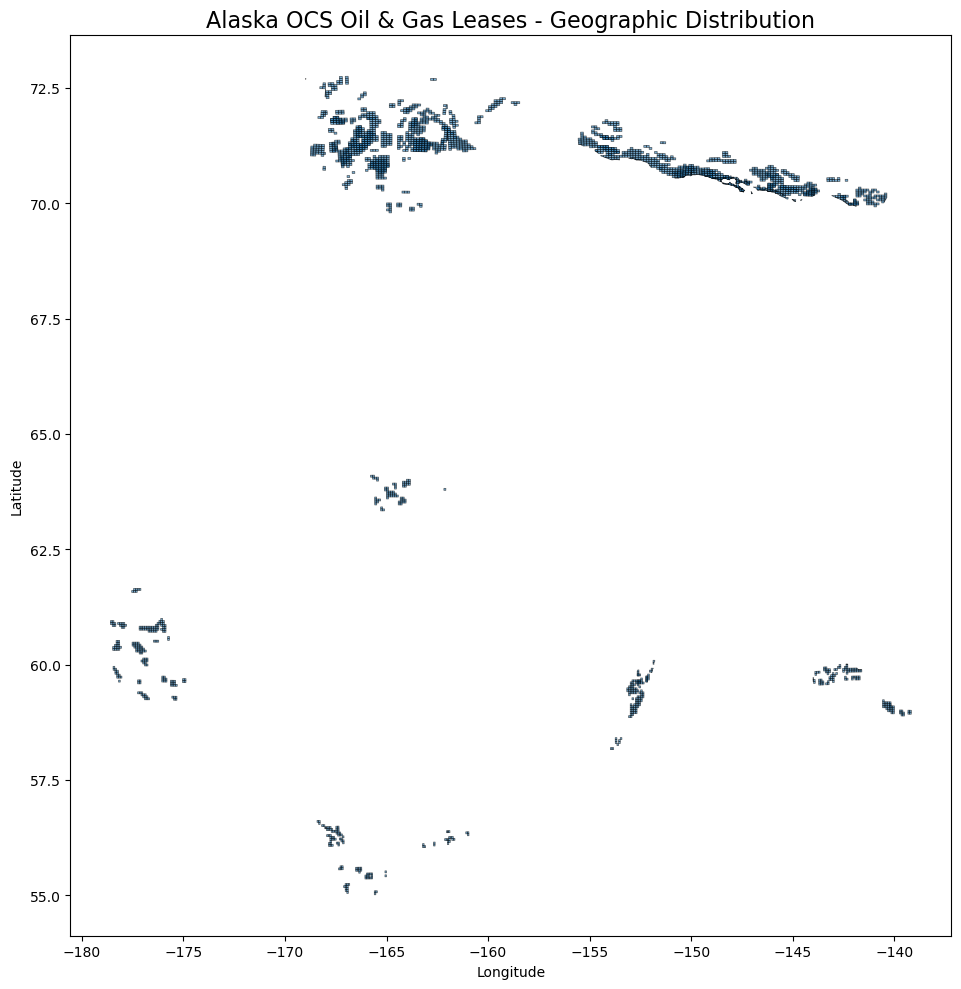

In [4]:
# Create a basic map of all leases
fig, ax = plt.subplots(figsize=(15, 10))
gdf.plot(ax=ax, alpha=0.6, edgecolor='black', linewidth=0.5)
ax.set_title('Alaska OCS Oil & Gas Leases - Geographic Distribution', fontsize=16)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.tight_layout()
plt.show()

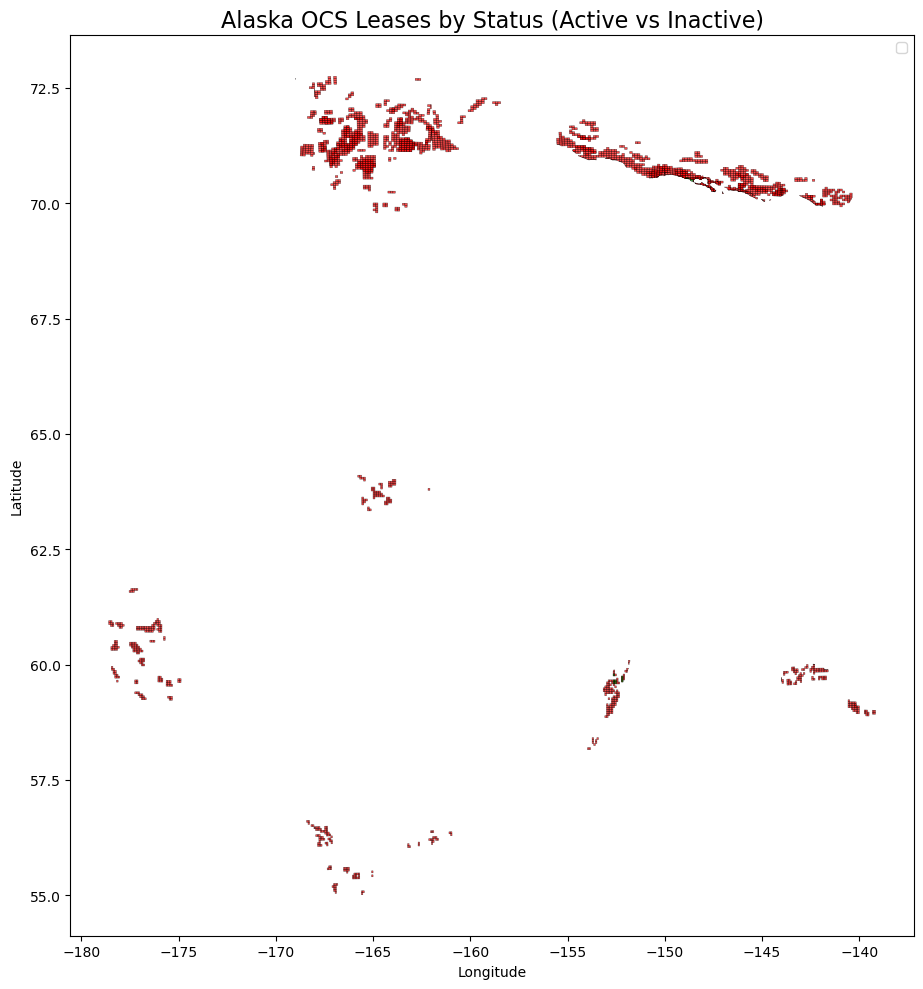

In [5]:
# Color-code by lease status
fig, ax = plt.subplots(figsize=(15, 10))

# Create color mapping for active/inactive
color_map = {'Y': 'green', 'N': 'red'}
gdf['color'] = gdf['LEASE_IS_ACTIVE'].map(color_map)

for status in gdf['LEASE_IS_ACTIVE'].unique():
    subset = gdf[gdf['LEASE_IS_ACTIVE'] == status]
    label = 'Active' if status == 'Y' else 'Inactive'
    subset.plot(ax=ax, color=color_map[status], alpha=0.7, 
                edgecolor='black', linewidth=0.3, label=label)

ax.set_title('Alaska OCS Leases by Status (Active vs Inactive)', fontsize=16)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend()
plt.tight_layout()
plt.show()

## 3. Interactive Mapping with Folium

In [6]:
# Create an interactive map
m = folium.Map(
    location=[center_lat, center_lon],
    zoom_start=6,
    tiles='OpenStreetMap'
)

# Add lease polygons to the map
# Sample a subset for performance (adjust as needed)
sample_size = min(500, len(gdf))  # Show up to 500 leases
gdf_sample = gdf.sample(n=sample_size, random_state=42)

for idx, row in gdf_sample.iterrows():
    # Create popup text with lease information
    popup_text = f"""
    <b>Lease Number:</b> {row['LEASE_NUMBER']}<br>
    <b>Company:</b> {row['BUS_ASC_NAME']}<br>
    <b>Status:</b> {'Active' if row['LEASE_IS_ACTIVE'] == 'Y' else 'Inactive'}<br>
    <b>Area:</b> {row['CURRENT_AREA']:.2f} hectares<br>
    <b>Bid Amount:</b> ${row['BID_AMOUNT']:,.2f}<br>
    <b>Planning Area:</b> {row['MMS_PLAN_AREA_CD']}
    """
    
    # Color based on active status
    color = 'green' if row['LEASE_IS_ACTIVE'] == 'Y' else 'red'
    
    # Add polygon to map
    folium.GeoJson(
        row['geometry'],
        style_function=lambda x, color=color: {
            'fillColor': color,
            'color': 'black',
            'weight': 1,
            'fillOpacity': 0.6
        },
        popup=folium.Popup(popup_text, max_width=300)
    ).add_to(m)

# Add a legend
legend_html = '''
<div style="position: fixed; 
            bottom: 50px; left: 50px; width: 150px; height: 90px; 
            background-color: white; border:2px solid grey; z-index:9999; 
            font-size:14px; padding: 10px">
<p><b>Lease Status</b></p>
<p><i class="fa fa-square" style="color:green"></i> Active</p>
<p><i class="fa fa-square" style="color:red"></i> Inactive</p>
</div>
'''
m.get_root().html.add_child(folium.Element(legend_html))

# Save the map
m.save('../visualizations/alaska_leases_map.html')
print(f"Interactive map saved to ../visualizations/alaska_leases_map.html")
print(f"Map shows a sample of {sample_size} leases")

# Display the map
m

Interactive map saved to ../visualizations/alaska_leases_map.html
Map shows a sample of 500 leases


## 4. Spatial Analysis by Planning Area

In [7]:
# Analyze lease distribution by planning area
planning_area_stats = gdf.groupby('MMS_PLAN_AREA_CD').agg({
    'LEASE_NUMBER': 'count',
    'CURRENT_AREA': 'sum',
    'BID_AMOUNT': 'sum',
    'LEASE_IS_ACTIVE': lambda x: (x == 'Y').sum()
}).round(2)

planning_area_stats.columns = ['Total_Leases', 'Total_Area_Hectares', 'Total_Bid_Amount', 'Active_Leases']
planning_area_stats['Active_Percentage'] = (planning_area_stats['Active_Leases'] / planning_area_stats['Total_Leases'] * 100).round(1)

print("Planning Area Statistics:")
print(planning_area_stats.sort_values('Total_Leases', ascending=False))

Planning Area Statistics:
                  Total_Leases  Total_Area_Hectares  Total_Bid_Amount  \
MMS_PLAN_AREA_CD                                                        
BFT                        963           2011003.02      3.688760e+09   
CHU                        866           1983041.83      1.863570e+09   
NAV                        186            428544.00      6.312283e+08   
GOA                        124            273932.57      6.925197e+08   
COK                        121            276531.69      4.080782e+08   
GEO                         97            221210.00      4.273438e+08   
NOR                         64            147456.00      3.252674e+08   
NAL                         23             49273.27      9.543950e+07   

                  Active_Leases  Active_Percentage  
MMS_PLAN_AREA_CD                                    
BFT                           3                0.3  
CHU                           0                0.0  
NAV                           0

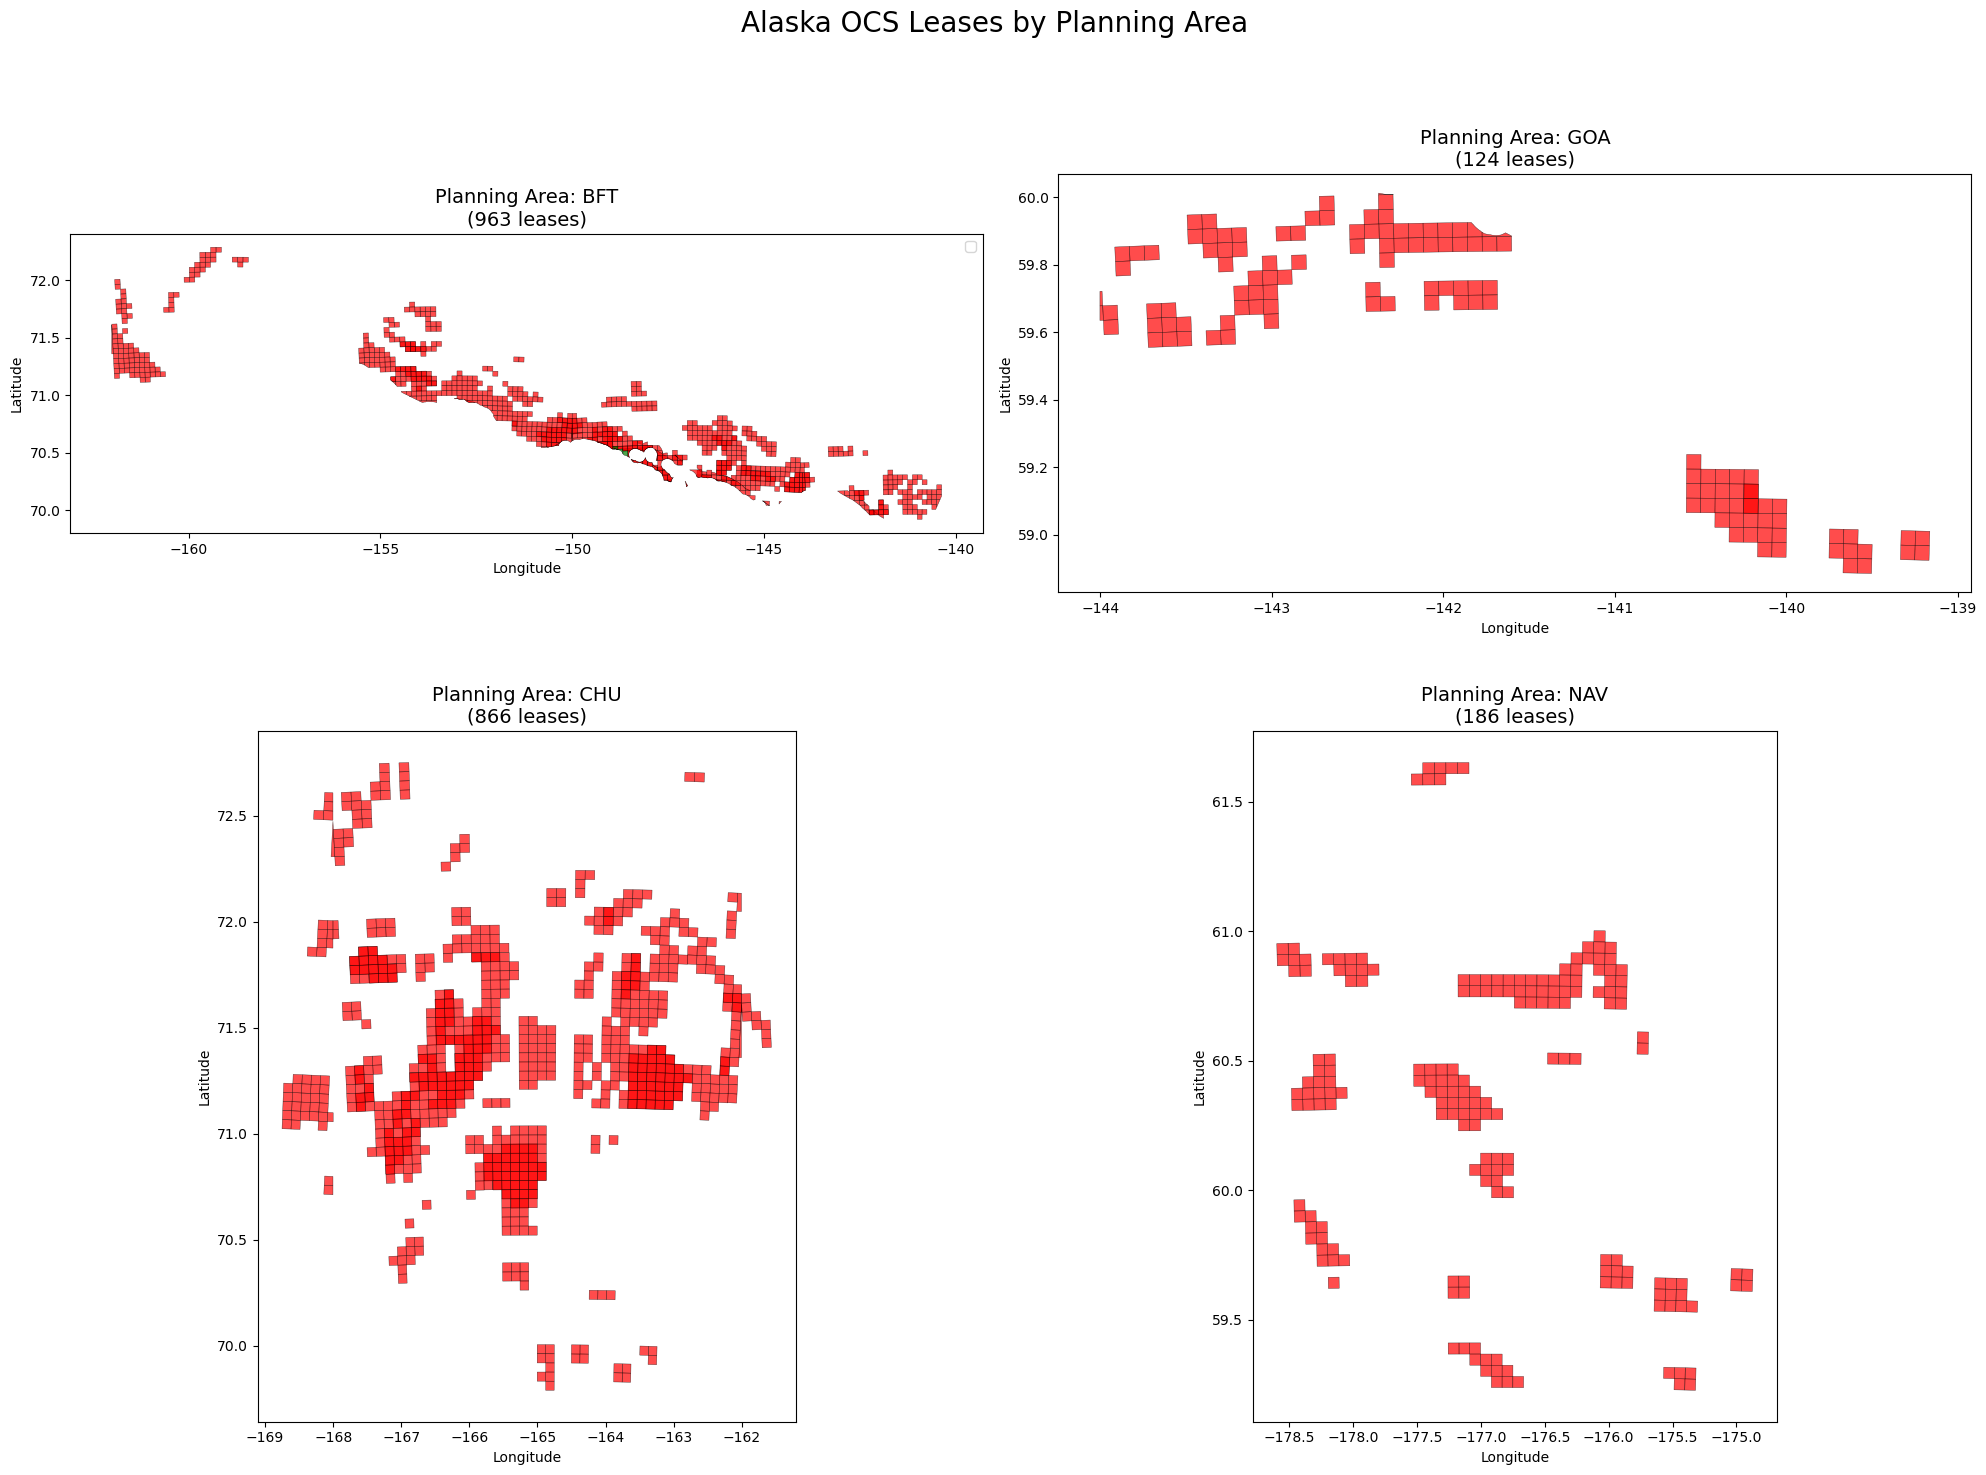

In [8]:
# Visualize planning areas separately
fig, axes = plt.subplots(2, 2, figsize=(20, 15))
fig.suptitle('Alaska OCS Leases by Planning Area', fontsize=20)

planning_areas = gdf['MMS_PLAN_AREA_CD'].unique()

for i, area in enumerate(planning_areas[:4]):  # Show top 4 areas
    ax = axes[i//2, i%2]
    area_data = gdf[gdf['MMS_PLAN_AREA_CD'] == area]
    
    # Color by active status
    for status in area_data['LEASE_IS_ACTIVE'].unique():
        subset = area_data[area_data['LEASE_IS_ACTIVE'] == status]
        color = 'green' if status == 'Y' else 'red'
        label = 'Active' if status == 'Y' else 'Inactive'
        subset.plot(ax=ax, color=color, alpha=0.7, edgecolor='black', linewidth=0.3, label=label)
    
    ax.set_title(f'Planning Area: {area}\n({len(area_data)} leases)', fontsize=14)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    if i == 0:  # Add legend to first subplot
        ax.legend()

plt.tight_layout()
plt.show()

## 5. Spatial Density Analysis

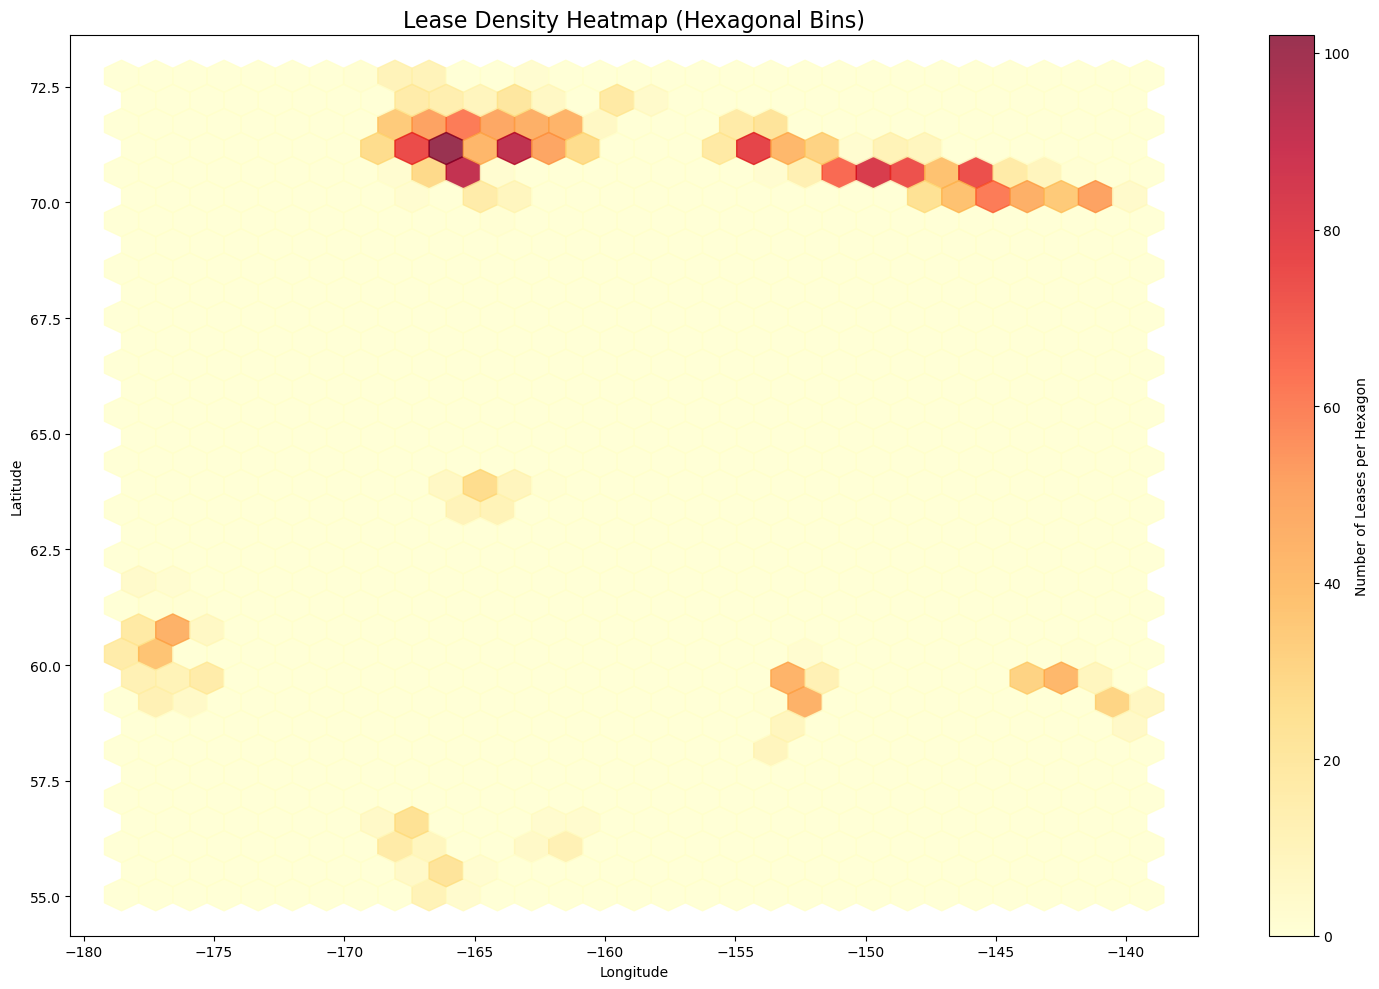

In [9]:
# Calculate lease density using centroids
gdf['centroid'] = gdf.geometry.centroid
gdf['lon'] = gdf.centroid.x
gdf['lat'] = gdf.centroid.y

# Create hexbin plot for density visualization
fig, ax = plt.subplots(figsize=(15, 10))

# Create hexbin plot
hb = ax.hexbin(gdf['lon'], gdf['lat'], gridsize=30, cmap='YlOrRd', alpha=0.8)
ax.set_title('Lease Density Heatmap (Hexagonal Bins)', fontsize=16)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Add colorbar
cb = plt.colorbar(hb, ax=ax)
cb.set_label('Number of Leases per Hexagon')

plt.tight_layout()
plt.show()

## 6. Lease Size and Value Spatial Analysis

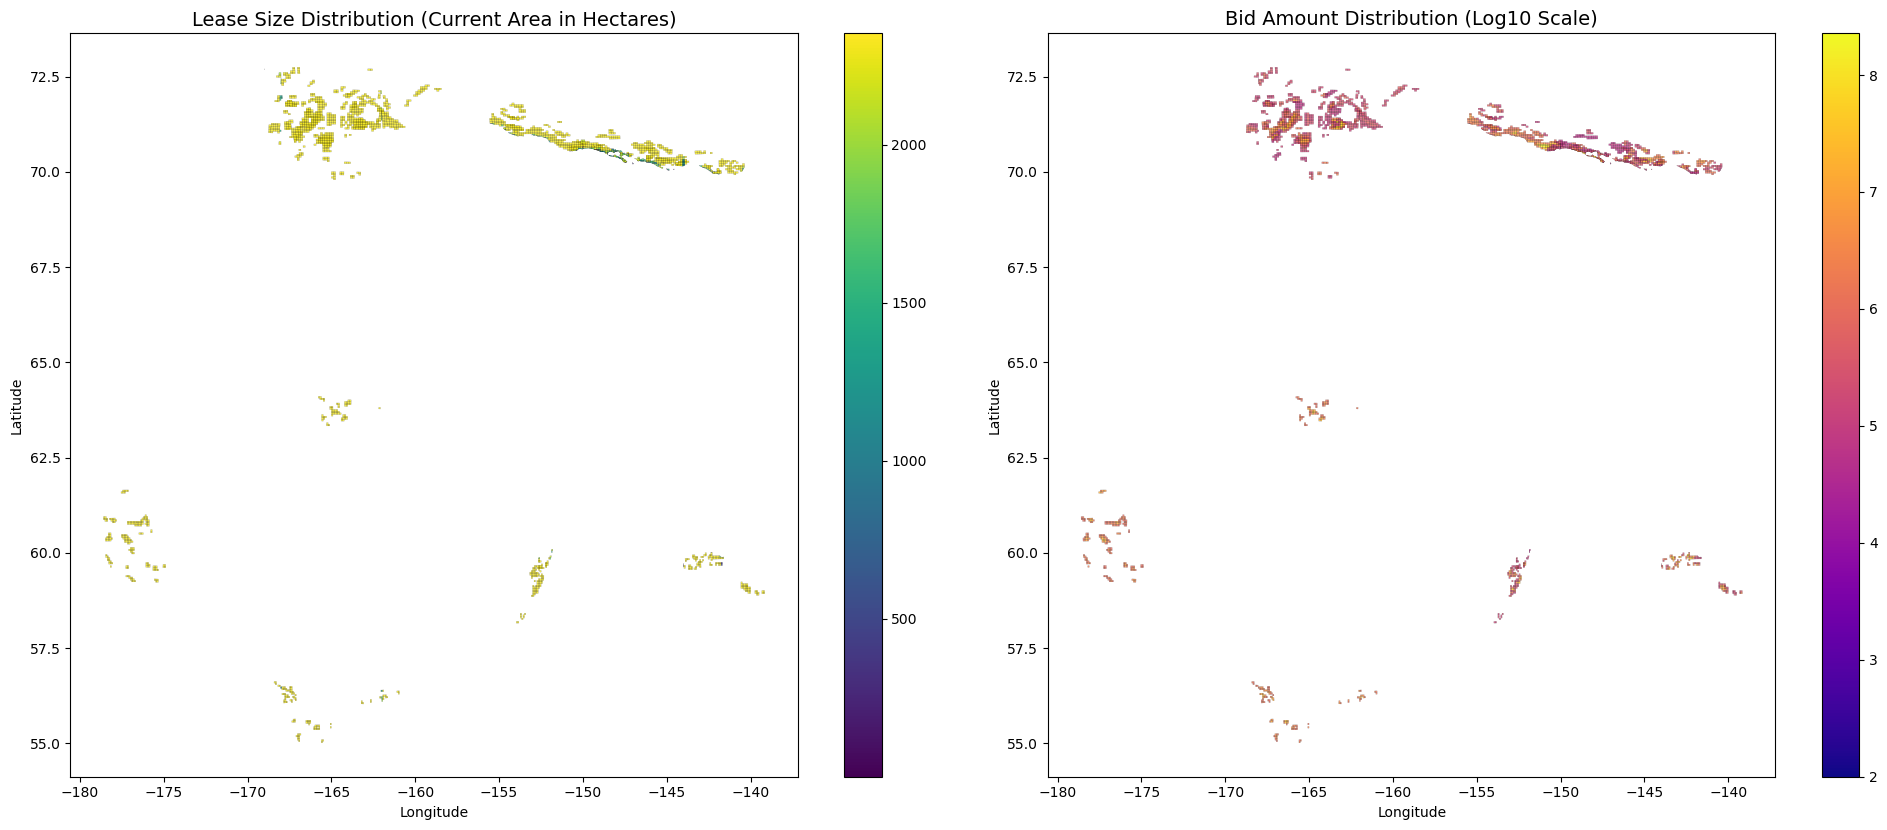

In [10]:
# Visualize lease size spatially
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Plot 1: Lease size
gdf.plot(column='CURRENT_AREA', cmap='viridis', legend=True, ax=axes[0], 
         edgecolor='black', linewidth=0.1, alpha=0.8)
axes[0].set_title('Lease Size Distribution (Current Area in Hectares)', fontsize=14)
axes[0].set_xlabel('Longitude')
axes[0].set_ylabel('Latitude')

# Plot 2: Bid amount (log scale for better visualization)
gdf['log_bid'] = np.log10(gdf['BID_AMOUNT'].replace(0, 1))  # Replace 0 with 1 for log
gdf.plot(column='log_bid', cmap='plasma', legend=True, ax=axes[1], 
         edgecolor='black', linewidth=0.1, alpha=0.8)
axes[1].set_title('Bid Amount Distribution (Log10 Scale)', fontsize=14)
axes[1].set_xlabel('Longitude')
axes[1].set_ylabel('Latitude')

plt.tight_layout()
plt.show()

## 7. Temporal-Spatial Analysis

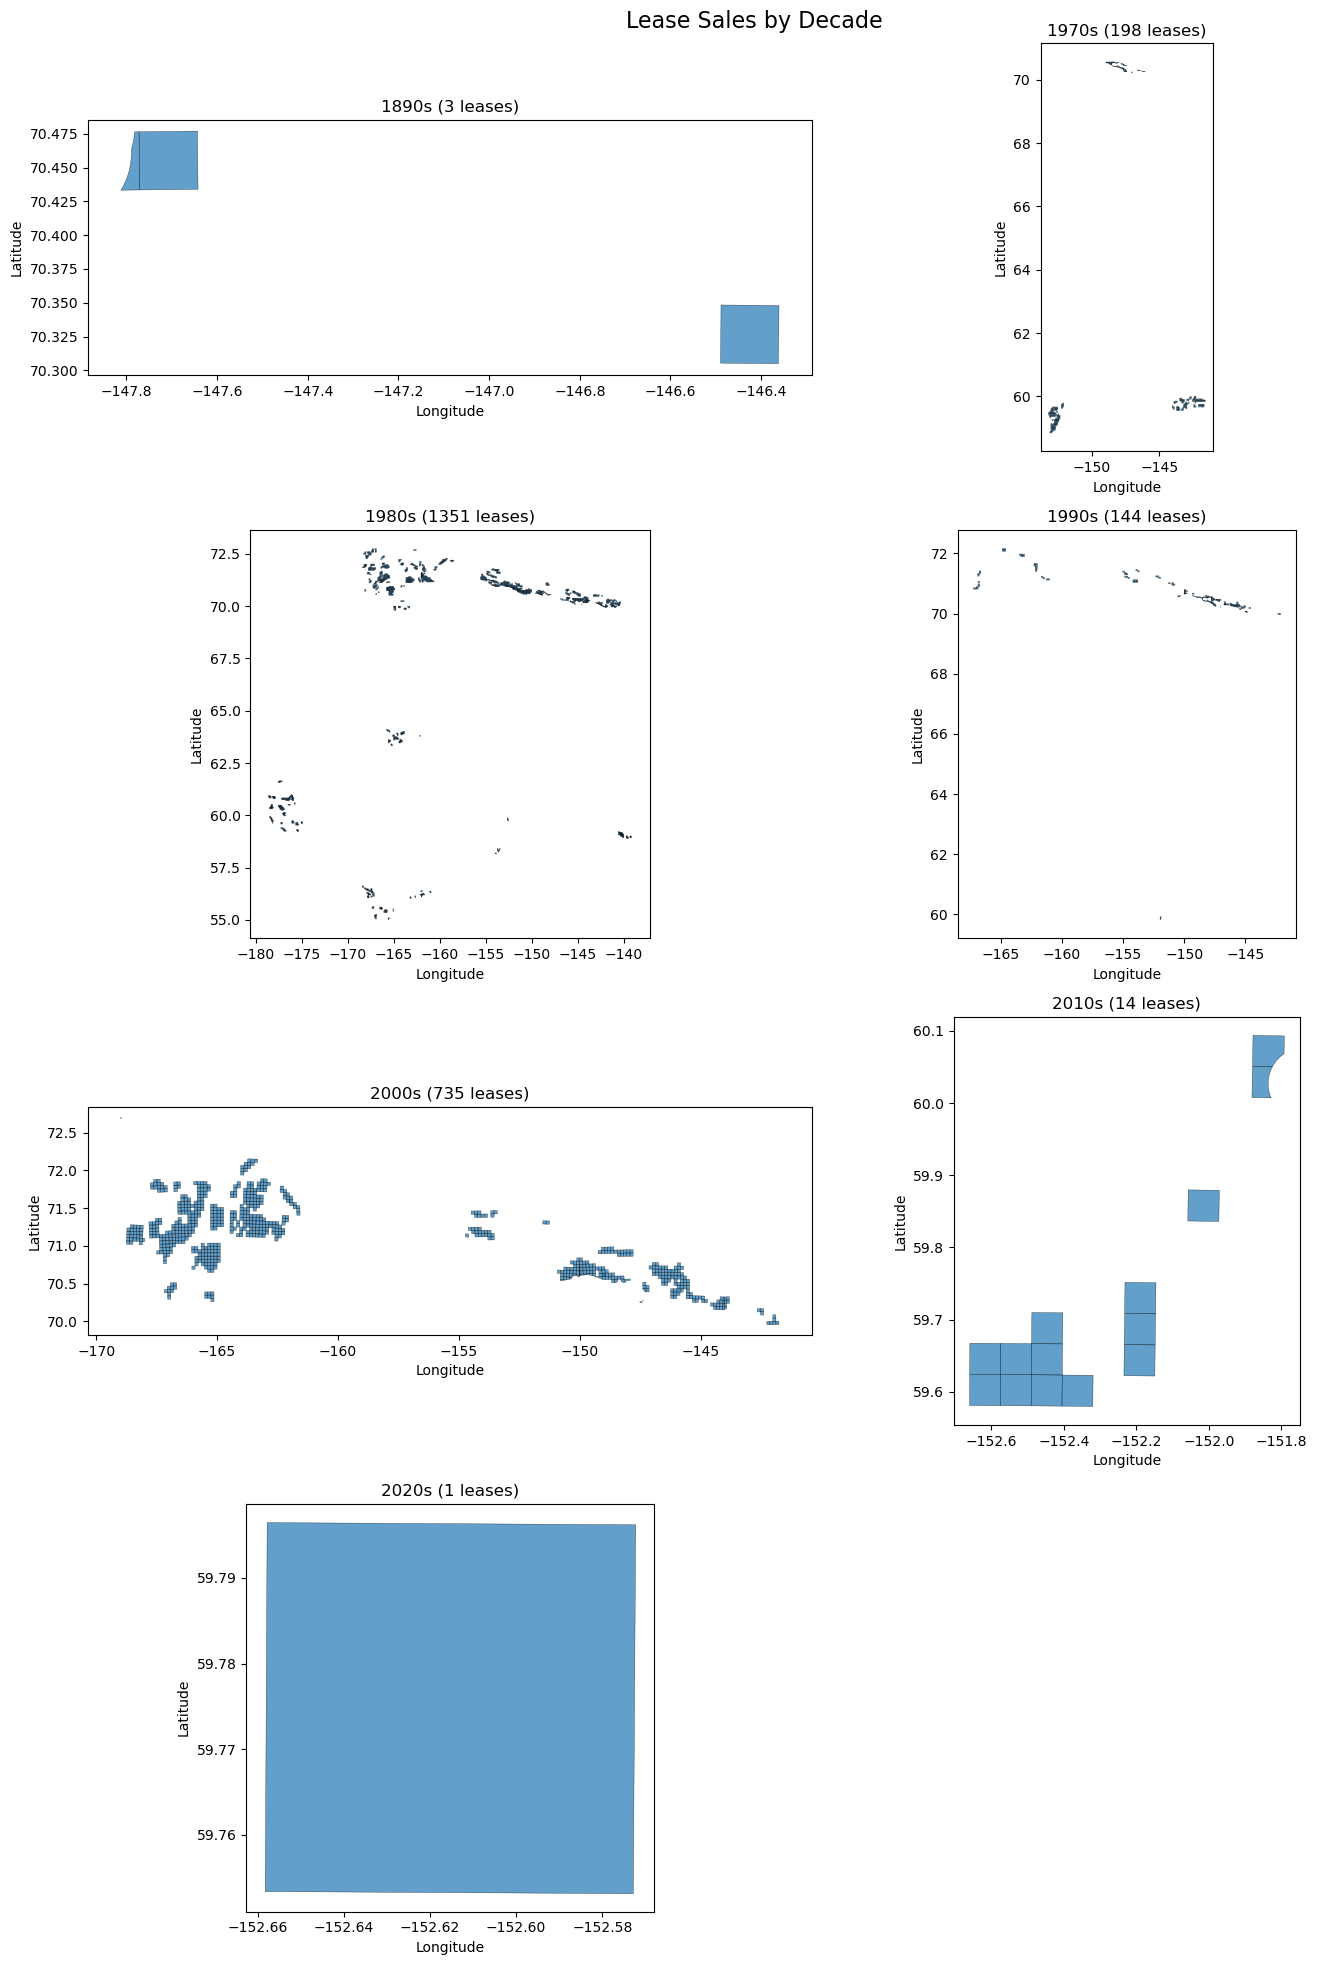

In [11]:
# Convert sale date and extract year
gdf['SALE_DATE'] = pd.to_datetime(gdf['SALE_DATE'], errors='coerce')
gdf['SALE_YEAR'] = gdf['SALE_DATE'].dt.year

# Analyze spatial patterns by decade
gdf['DECADE'] = (gdf['SALE_YEAR'] // 10) * 10

# Plot leases by decade
decades = sorted(gdf['DECADE'].dropna().unique())
n_decades = len(decades)
cols = 2
rows = (n_decades + 1) // 2

fig, axes = plt.subplots(rows, cols, figsize=(15, 5*rows))
fig.suptitle('Lease Sales by Decade', fontsize=16)

for i, decade in enumerate(decades):
    ax = axes[i//cols, i%cols] if rows > 1 else axes[i%cols]
    decade_data = gdf[gdf['DECADE'] == decade]
    
    if len(decade_data) > 0:
        decade_data.plot(ax=ax, alpha=0.7, edgecolor='black', linewidth=0.3)
        ax.set_title(f'{int(decade)}s ({len(decade_data)} leases)', fontsize=12)
        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')

# Hide empty subplots
if n_decades < rows * cols:
    for i in range(n_decades, rows * cols):
        ax = axes[i//cols, i%cols] if rows > 1 else axes[i%cols]
        ax.set_visible(False)

plt.tight_layout()
plt.show()

## 8. Export Key Findings

In [12]:
# Summary of geospatial findings
print("GEOSPATIAL ANALYSIS SUMMARY")
print("=" * 50)
print(f"Total lease area coverage: {gdf['CURRENT_AREA'].sum():,.2f} hectares")
print(f"Average lease size: {gdf['CURRENT_AREA'].mean():,.2f} hectares")
print(f"Geographic extent:")
print(f"  Latitude range: {bounds[1]:.4f}° to {bounds[3]:.4f}°")
print(f"  Longitude range: {bounds[0]:.4f}° to {bounds[2]:.4f}°")

print("\nPlanning Area Distribution:")
for area in planning_area_stats.index:
    stats = planning_area_stats.loc[area]
    print(f"  {area}: {stats['Total_Leases']} leases, {stats['Active_Percentage']:.1f}% active")

print("\nTemporal Patterns:")
decade_counts = gdf['DECADE'].value_counts().sort_index()
for decade, count in decade_counts.items():
    if not pd.isna(decade):
        print(f"  {int(decade)}s: {count} leases")

GEOSPATIAL ANALYSIS SUMMARY
Total lease area coverage: 5,393,306.99 hectares
Average lease size: 2,204.95 hectares
Geographic extent:
  Latitude range: 55.0104° to 72.7511°
  Longitude range: -178.5980° to -139.1631°

Planning Area Distribution:
  BFT: 963.0 leases, 0.3% active
  CHU: 866.0 leases, 0.0% active
  COK: 121.0 leases, 6.6% active
  GEO: 97.0 leases, 0.0% active
  GOA: 124.0 leases, 0.0% active
  NAL: 23.0 leases, 0.0% active
  NAV: 186.0 leases, 0.0% active
  NOR: 64.0 leases, 0.0% active

Temporal Patterns:
  1890s: 3 leases
  1970s: 198 leases
  1980s: 1351 leases
  1990s: 144 leases
  2000s: 735 leases
  2010s: 14 leases
  2020s: 1 leases
